In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

# -----------------------------------------------------------
# Function: f
# Purpose: Defines the right-hand side of the ODE: y' = y-x^2+1, y(0)=0.5
# Input: x (float), y (float)
# Output: dy/dx = f(x, y) (float)
# -----------------------------------------------------------
def f(x, y):
    return y - x**2 + 1

# -----------------------------------------------------------
# Function: y_exact
# Purpose: Returns the exact solution to the ODE
# Input: x (float or np.ndarray)
# Output: y(x) = exact solution value(s)
# -----------------------------------------------------------
def y_exact(x):
    return (x + 1)**2 - 0.5 * np.exp(x)

# -----------------------------------------------------------
# Function: quadratic_spline_solver
# Purpose: Solves the ODE y' = f(x, y) using the quadratic spline method (m = 2)
#          Builds a piecewise quadratic spline S(x) defined on each interval [x_i, x_{i+1}]
#
# Input:
#   f   - function f(x, y), the right-hand side of the ODE
#   x0  - initial x value (float)
#   y0  - initial y value (float)
#   X   - endpoint of interval (float)
#   h   - step size (float)
#
# Output:
#   xs      - list of x-values at node points (numpy array)
#   ys      - list of y-values computed at each node (numpy array)
#   coeffs  - list of [a_i, b_i, c_i] for each spline segment S_i(x)
#
# On each subinterval [x_i, x_{i+1}], the quadratic spline is:
#   S_i(x) = a_i/2 * (x - x_i)^2 + b_i * (x - x_i) + c_i
#           = a_i/2 * (x - x_i)^2 + b_i * (x - x_i) + y_i
#
# The method enforces:
#   - S_i(x_i) = y_i         (initial value)
#   - S_i'(x_i) = f(x_i, y_i)  (derivative matches ODE at x_i)
#   - S_i'(x_{i+1}) = f(x_{i+1}, y_{i+1}) (match ODE at x_{i+1}, solved implicitly)
def quadratic_spline_solver(f, x0, y0, X, h):
    # Step 1: Compute number of steps
    n = int((X - x0) / h)

    # Initialize lists to store node positions and solution values
    xs = [x0]   # List of x_i
    ys = [y0]   # List of y_i = S(x_i)
    coeffs = [] # Store spline coefficients for each interval [a_i, b_i, c_i]

    for i in range(n):
        x_i = xs[-1]  # Current x_i
        y_i = ys[-1]  # Current y_i = S(x_i)
        b_i = f(x_i, y_i)  # Enforce S_i'(x_i) = f(x_i, y_i), so b_i = f(x_i, y_i)

        # -------------------------------------------------------
        # Now determine y_{i+1} = S(x_{i+1}) using the ODE condition:
        # Enforce: S_i'(x_{i+1}) = f(x_{i+1}, y_{i+1})
        #
        # For a quadratic spline:
        #   S'(x) = a_i(x - x_i) + b_i
        # So:
        #   S'(x_{i+1}) = a_i * h + b_i
        #
        # But:
        #   a_i = 2 * (y_{i+1} - y_i - h * b_i) / h^2   ← derived from integrating S'(x)
        # Therefore:
        #   S'(x_{i+1}) = a_i * h + b_i
        #              = f(x_{i+1}, y_{i+1})  ← implicit equation to solve
        # -------------------------------------------------------
        def residual(y_next):
          # Compute a_i in terms of y_{i+1} (denoted here as y_next)
          a_i = 2*(y_next - y_i - h * b_i) / h**2
          # Compute S'(x_{i+1}) = a_i * h + b_i
          S_prime = a_i * h + b_i
          return S_prime - f(x_i + h, y_next)

        # Use Euler prediction as initial guess
        y_guess = y_i + h * b_i
        # Solve the residual equation for y_{i+1} using scipy's root solver
        sol = root(residual, y_guess)

        if not sol.success:
            raise RuntimeError(f"Root finding failed at step {i+1}")
        # Get the numerical value of y_{i+1}
        y_next = sol.x[0]
        # Recompute a_i with known y_{i+1}
        a_i = 2*(y_next - y_i - h * b_i) / h**2
        c_i = y_i
        # Save the spline coefficients for interval [x_i, x_{i+1}]
        coeffs.append([a_i, b_i, c_i])
        # Append new point
        xs.append(x_i + h)
        ys.append(y_next)

    return np.array(xs), np.array(ys), coeffs

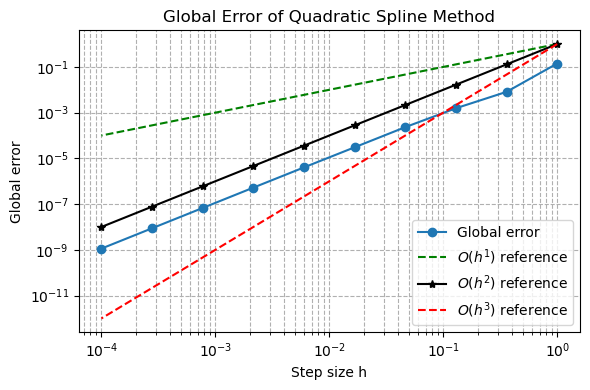

In [4]:
# global error test
hs = np.logspace(0,-4,10)
global_errors = []

for h in hs:
    xs, ys, _ = quadratic_spline_solver(f, 0, 0.5, 1.0, h)
    exact = y_exact(xs)
    global_err = np.abs(exact[1:] - ys[1:])
    global_errors.append(np.max(global_err))

# Plot log-log of local error vs h
plt.figure(figsize=(6, 4))
plt.loglog(hs, global_errors, 'o-', label='Global error')
plt.loglog(hs, [h for h in hs], 'g--', label='$O(h^1)$ reference')
plt.loglog(hs, [h**2 for h in hs], 'k*-', label='$O(h^2)$ reference')
plt.loglog(hs, [h**3 for h in hs], 'r--', label='$O(h^3)$ reference')

plt.xlabel('Step size h')
plt.ylabel('Global error')
plt.title('Global Error of Quadratic Spline Method')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

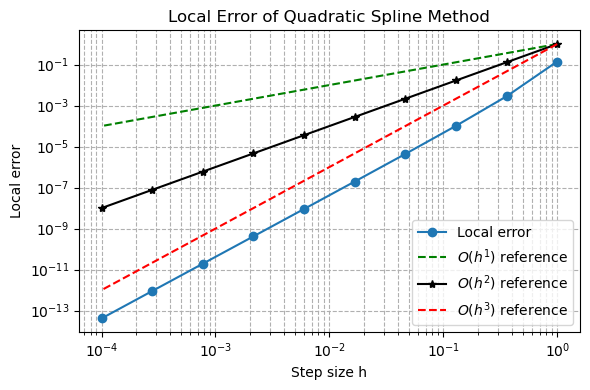

In [5]:
local_errors = []

for h in hs:
    xs, ys, _ = quadratic_spline_solver(f, 0, 0.5, 1.0, h)
    exact = y_exact(xs)
    local_err = np.abs(exact[1] - ys[1])
    local_errors.append(local_err)

# Plot log-log of local error vs h
plt.figure(figsize=(6, 4))
plt.loglog(hs, local_errors, 'o-', label='Local error')
plt.loglog(hs, [h for h in hs], 'g--', label='$O(h^1)$ reference')
plt.loglog(hs, [h**2 for h in hs], 'k*-', label='$O(h^2)$ reference')
plt.loglog(hs, [h**3 for h in hs], 'r--', label='$O(h^3)$ reference')

plt.xlabel('Step size h')
plt.ylabel('Local error')
plt.title('Local Error of Quadratic Spline Method')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

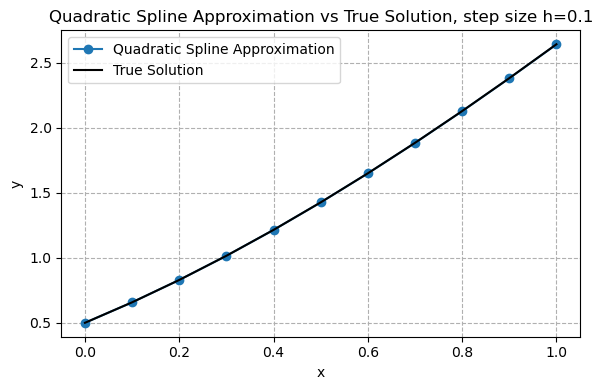

In [6]:
h = 0.1

xs, ys, _ = quadratic_spline_solver(f, 0, 0.5, 1.0, h)
exact = y_exact(xs)


plt.figure(figsize=(6, 4))
plt.plot(xs, ys, 'o-', label='Quadratic Spline Approximation')
plt.plot(xs, y_exact(xs), 'k-', label='True Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Spline Approximation vs True Solution, step size h='+str(h))
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

In [7]:
# -----------------------------------------------------------
# Function: f
# Purpose: Defines the right-hand side of the ODE: y' = y+1, y(0)=0
# Input: x (float), y (float)
# Output: dy/dx = f(x, y) (float)
# -----------------------------------------------------------
def f(x, y):
    return y + 1

def y_exact(x):
    return np.exp(x)-1

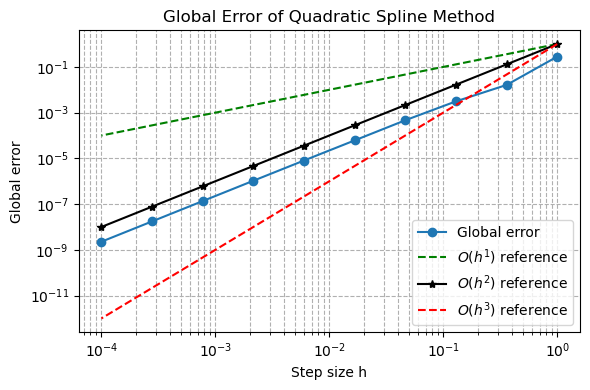

In [8]:
# global error test
hs = np.logspace(0,-4,10)
global_errors = []

for h in hs:
    xs, ys, _ = quadratic_spline_solver(f, 0, 0, 1.0, h)
    exact = y_exact(xs)
    global_err = np.abs(exact[1:] - ys[1:])
    global_errors.append(np.max(global_err))

# Plot log-log of local error vs h
plt.figure(figsize=(6, 4))
plt.loglog(hs, global_errors, 'o-', label='Global error')
plt.loglog(hs, [h for h in hs], 'g--', label='$O(h^1)$ reference')
plt.loglog(hs, [h**2 for h in hs], 'k*-', label='$O(h^2)$ reference')
plt.loglog(hs, [h**3 for h in hs], 'r--', label='$O(h^3)$ reference')

plt.xlabel('Step size h')
plt.ylabel('Global error')
plt.title('Global Error of Quadratic Spline Method')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

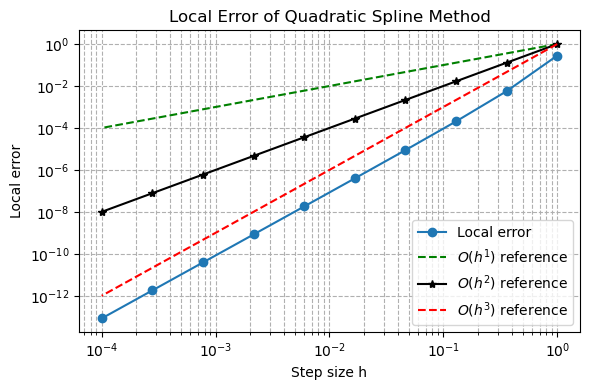

In [9]:
local_errors = []

for h in hs:
    xs, ys, _ = quadratic_spline_solver(f, 0, 0, 1.0, h)
    exact = y_exact(xs)
    local_err = np.abs(exact[1] - ys[1])
    local_errors.append(local_err)

# Plot log-log of local error vs h
plt.figure(figsize=(6, 4))
plt.loglog(hs, local_errors, 'o-', label='Local error')
plt.loglog(hs, [h for h in hs], 'g--', label='$O(h^1)$ reference')
plt.loglog(hs, [h**2 for h in hs], 'k*-', label='$O(h^2)$ reference')
plt.loglog(hs, [h**3 for h in hs], 'r--', label='$O(h^3)$ reference')

plt.xlabel('Step size h')
plt.ylabel('Local error')
plt.title('Local Error of Quadratic Spline Method')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

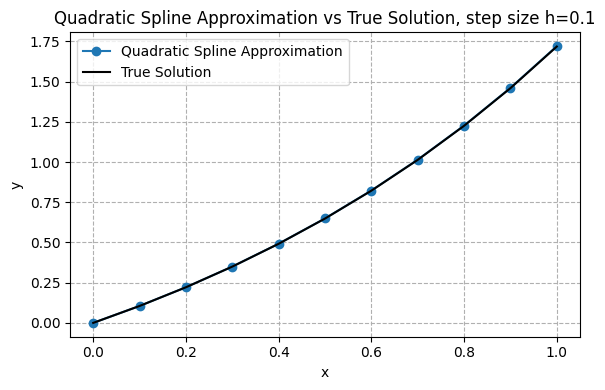

In [ ]:
h = 0.1

xs, ys, _ = quadratic_spline_solver(f, 0, 0, 1.0, h)
exact = y_exact(xs)


plt.figure(figsize=(6, 4))
plt.plot(xs, ys, 'o-', label='Quadratic Spline Approximation')
plt.plot(xs, y_exact(xs), 'k-', label='True Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Spline Approximation vs True Solution, step size h='+str(h))
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()